In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [19]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import joblib

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')
print("NLTK data downloaded.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FBC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FBC\AppData\Roaming\nltk_data...


NLTK data downloaded.


In [22]:
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', 200)
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

In [23]:
DATA_PATH = 'data/financial_news.csv'
try:
    df = pd.read_csv(DATA_PATH, encoding='latin-1', on_bad_lines='skip')
    print("Data loaded.")
except Exception as e:
    print(f"Error: {e}")

Data loaded.


In [24]:
if len(df.columns) == 2:
    df.columns = ['Sentence', 'Sentiment']

In [25]:
df

,Sentence,Sentiment
0,"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and power...",positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real possibility",negative
2,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
3,"According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .",neutral
4,"The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .",neutral
...,...,...
5837,RISING costs have forced packaging producer Huhtamaki to axe 90 jobs at its Hampshire manufacturing plant .,negative
5838,Nordic Walking was first used as a summer training method by cross-country skiers .,neutral
5839,"According shipping company Viking Line , the EU decision will have a significant financial impact .",neutral
5840,"In the building and home improvement trade , sales decreased by 22.5 % to EUR 201.4 mn .",neutral


In [26]:
df.head()

,Sentence,Sentiment
0,"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and power...",positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real possibility",negative
2,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
3,"According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .",neutral
4,"The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .",neutral


In [27]:
display(df.tail())

,Sentence,Sentiment
5837,RISING costs have forced packaging producer Huhtamaki to axe 90 jobs at its Hampshire manufacturing plant .,negative
5838,Nordic Walking was first used as a summer training method by cross-country skiers .,neutral
5839,"According shipping company Viking Line , the EU decision will have a significant financial impact .",neutral
5840,"In the building and home improvement trade , sales decreased by 22.5 % to EUR 201.4 mn .",neutral
5841,HELSINKI AFX - KCI Konecranes said it has won an order for four hot metal ladle cranes from Indian steel producer Bhushan Steel and Strips Ltd. .,positive


In [28]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None


In [29]:
print(df.isnull().sum())

Sentence     0
Sentiment    0
dtype: int64


In [30]:
df.dropna(inplace=True)
print("Nulls dropped.")

Nulls dropped.


In [31]:
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 6


In [32]:
df.drop_duplicates(inplace=True)
print("Duplicates dropped.")

Duplicates dropped.


In [33]:
print(df['Sentiment'].value_counts())

Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64


C:\Users\FBC\AppData\Local\Temp\ipykernel_18828\4289041566.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


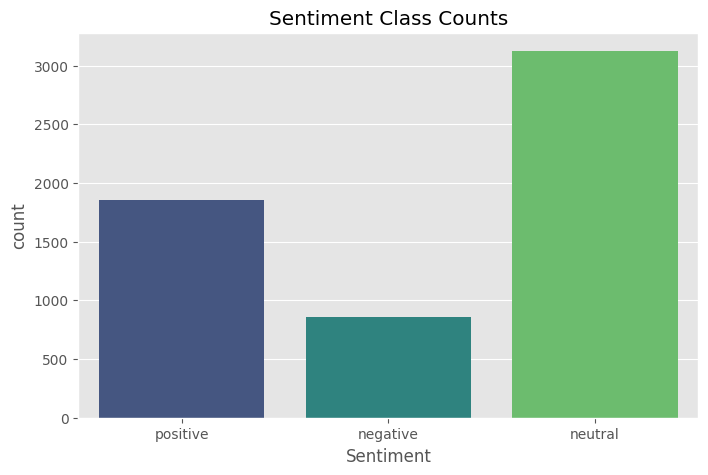

In [34]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title("Sentiment Class Counts")
plt.show()

In [35]:
df['Length'] = df['Sentence'].apply(len)

In [36]:
df['Word_Count'] = df['Sentence'].apply(lambda x: len(x.split()))

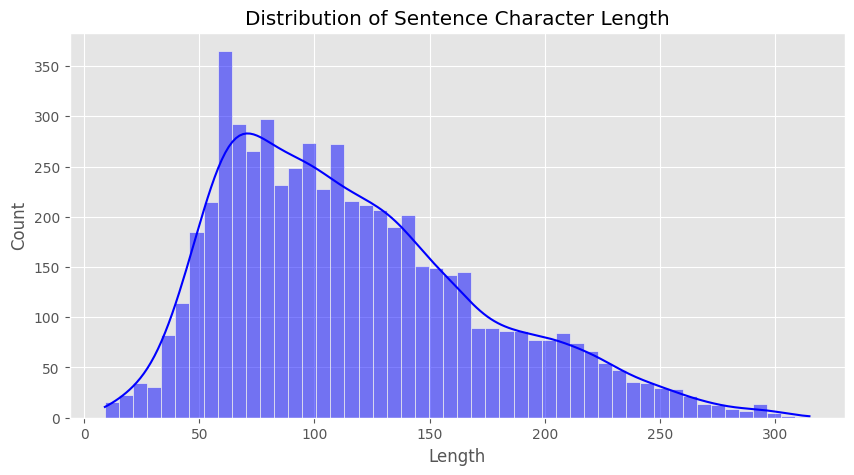

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Sentence Character Length')
plt.show()

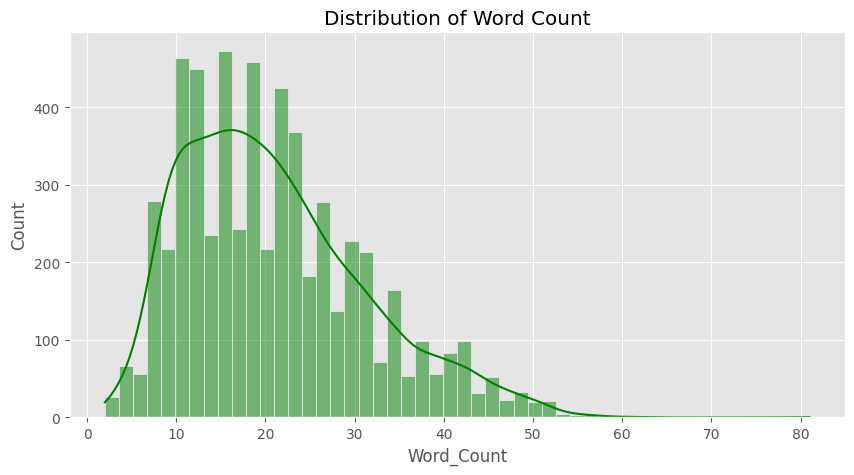

In [38]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Word_Count'], bins=50, kde=True, color='green')
plt.title('Distribution of Word Count')
plt.show()

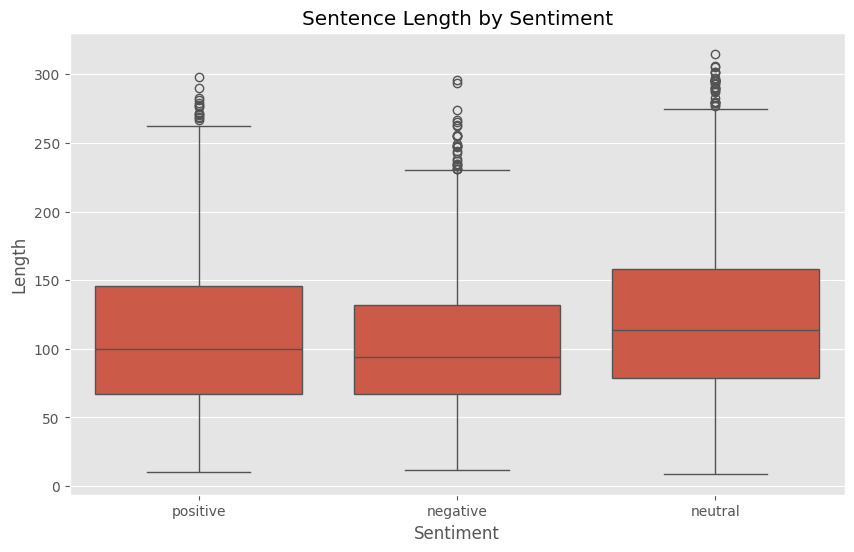

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Length', data=df)
plt.title('Sentence Length by Sentiment')
plt.show()

In [40]:
stop_words = set(stopwords.words('english'))

In [41]:
stop_words.update(['said', 'year', 'company'])

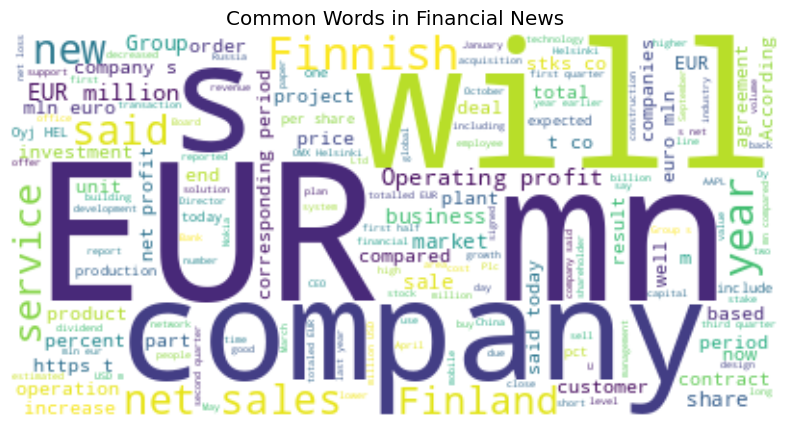

In [42]:
text = " ".join(review for review in df.Sentence)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Financial News")
plt.show()

In [43]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    return text

In [44]:
df['Cleaned_Text'] = df['Sentence'].apply(clean_text)

In [45]:
lemmatizer = WordNetLemmatizer()

In [46]:
def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [47]:
df['Final_Text'] = df['Cleaned_Text'].apply(lemmatize_text)

In [48]:
display(df[['Sentence', 'Final_Text']].head())

,Sentence,Final_Text
0,"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and power...",geosolutions technology leverage benefon gps solution providing location based search technology community platform location relevant multimedia content new powerful commercial model
1,"$ESI on lows, down $1.50 to $2.50 BK a real possibility",esi low bk real possibility
2,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",last quarter componenta net sale doubled eurm eurm period earlier moved zero pretax profit pretax loss eurm
3,"According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .",according finnishrussian chamber commerce major construction company finland operating russia
4,"The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .",swedish buyout firm sold remaining percent stake almost eighteen month taking public finland


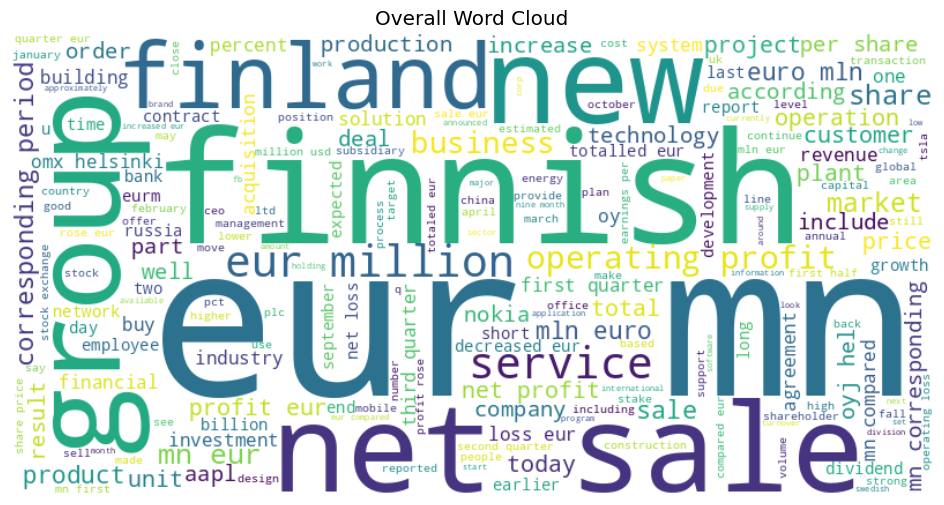

In [49]:
all_text = ' '.join(df['Final_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud')
plt.show()

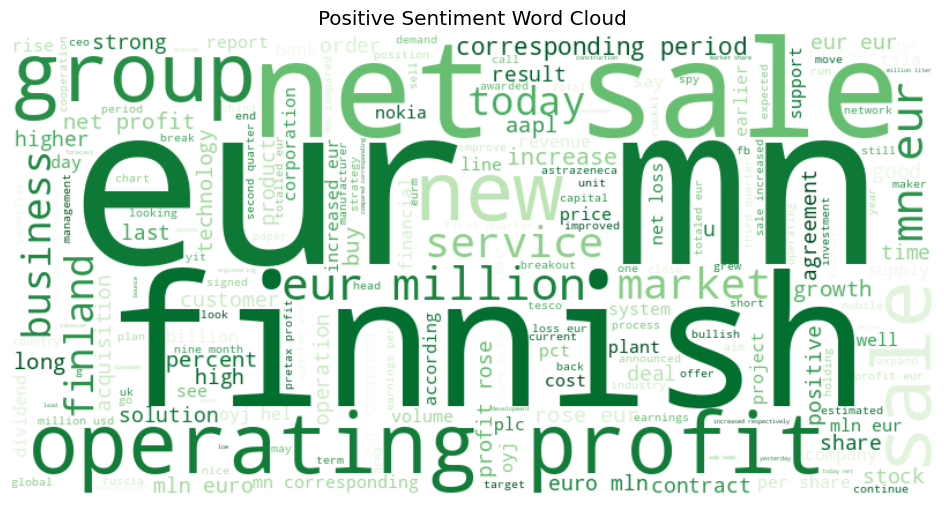

In [50]:
pos_text = ' '.join(df[df['Sentiment']=='positive']['Final_Text'])
wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(pos_text)
plt.figure(figsize=(12, 6))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')
plt.show()

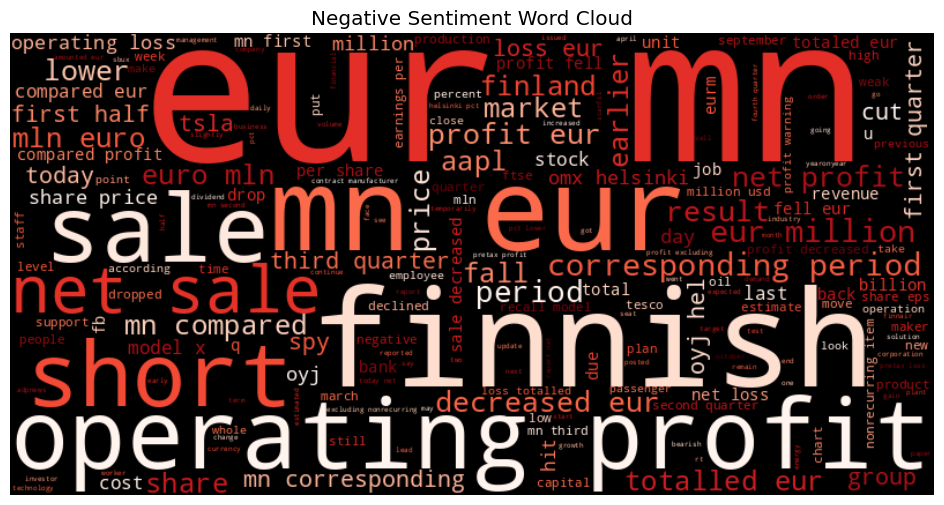

In [51]:
neg_text = ' '.join(df[df['Sentiment']=='negative']['Final_Text'])
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(neg_text)
plt.figure(figsize=(12, 6))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

In [52]:
def get_top_ngrams(corpus, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

In [53]:
top_bigrams = get_top_ngrams(df['Final_Text'], n=2)
print("Top 10 Bigrams:", top_bigrams)

Top 10 Bigrams: [('eur mn', np.int64(774)), ('net sale', np.int64(276)), ('eur million', np.int64(245)), ('operating profit', np.int64(241)), ('mn eur', np.int64(195)), ('corresponding period', np.int64(148)), ('euro mln', np.int64(135)), ('mln euro', np.int64(134)), ('net profit', np.int64(127)), ('profit eur', np.int64(116))]


C:\Users\FBC\AppData\Local\Temp\ipykernel_18828\2225609480.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y), y=list(x), palette='plasma')


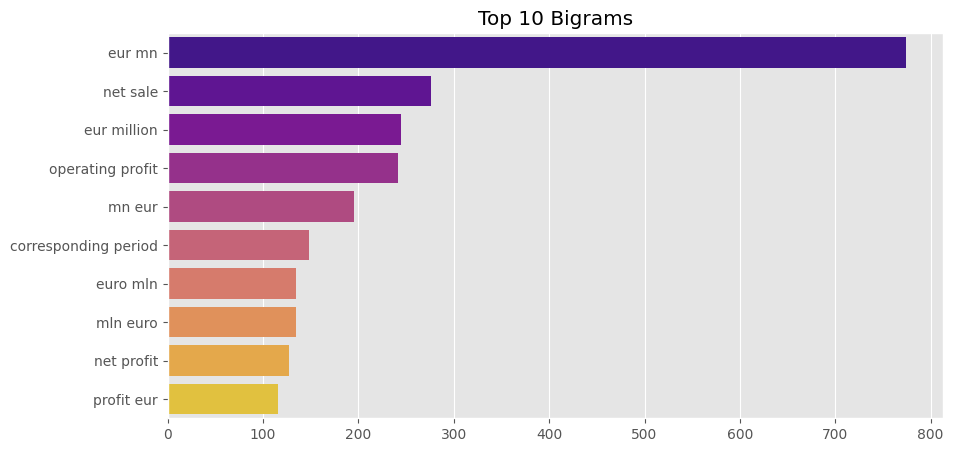

In [54]:
x, y = zip(*top_bigrams)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(y), y=list(x), palette='plasma')
plt.title('Top 10 Bigrams')
plt.show()

In [55]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Sentiment'])
print(f"Classes Mapped: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Classes Mapped: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [56]:
X_raw = df['Final_Text']
y = df['Label']

In [57]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [59]:
X_train = tfidf.fit_transform(X_train_raw).toarray()
print(f"X_train shape: {X_train.shape}")

X_train shape: (4668, 5000)


In [60]:
X_test = tfidf.transform(X_test_raw).toarray()
print(f"X_test shape: {X_test.shape}")

X_test shape: (1168, 5000)


In [61]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [62]:
y_pred_nb = nb_model.predict(X_test)

In [63]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6883561643835616


In [64]:
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.44      0.04      0.07       172
     neutral       0.69      0.93      0.79       625
    positive       0.70      0.58      0.64       371

    accuracy                           0.69      1168
   macro avg       0.61      0.52      0.50      1168
weighted avg       0.66      0.69      0.64      1168



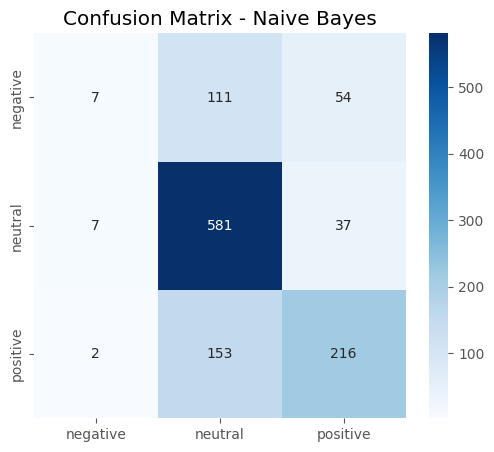

In [65]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

In [66]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [67]:
y_pred_lr = lr_model.predict(X_test)

In [68]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.672945205479452


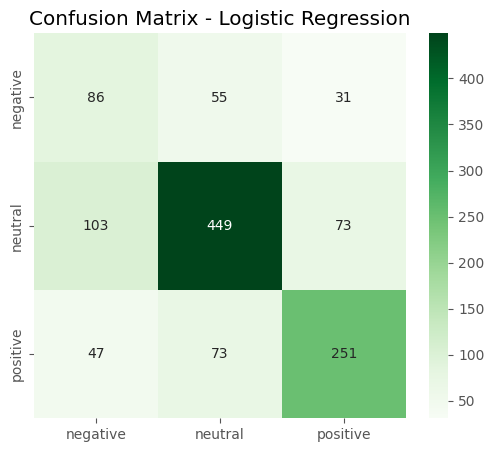

In [69]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [70]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.6386986301369864


In [72]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_nb.fit(X_train, y_train)

,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.1, 0.5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1.0


In [73]:
print("Best Alpha:", grid_nb.best_params_)
best_nb = grid_nb.best_estimator_

Best Alpha: {'alpha': 1.0}


In [74]:
y_pred_tuned = best_nb.predict(X_test)
print("Tuned NB Accuracy:", accuracy_score(y_test, y_pred_tuned))

Tuned NB Accuracy: 0.6883561643835616


In [75]:
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = best_nb.predict_proba(X_test)

In [76]:
fpr, tpr, _ = roc_curve(y_test_bin[:, 2], y_score[:, 2])
roc_auc = auc(fpr, tpr)

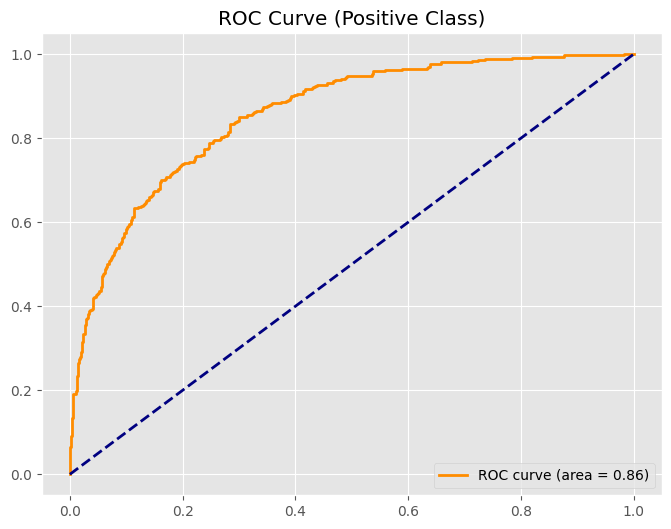

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve (Positive Class)')
plt.legend(loc="lower right")
plt.show()

In [78]:
models = ['Naive Bayes', 'Logistic Reg', 'Random Forest', 'Tuned NB']
accs = [accuracy_score(y_test, y_pred_nb), 
        accuracy_score(y_test, y_pred_lr), 
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_tuned)]

C:\Users\FBC\AppData\Local\Temp\ipykernel_18828\1425506699.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accs, palette='magma')


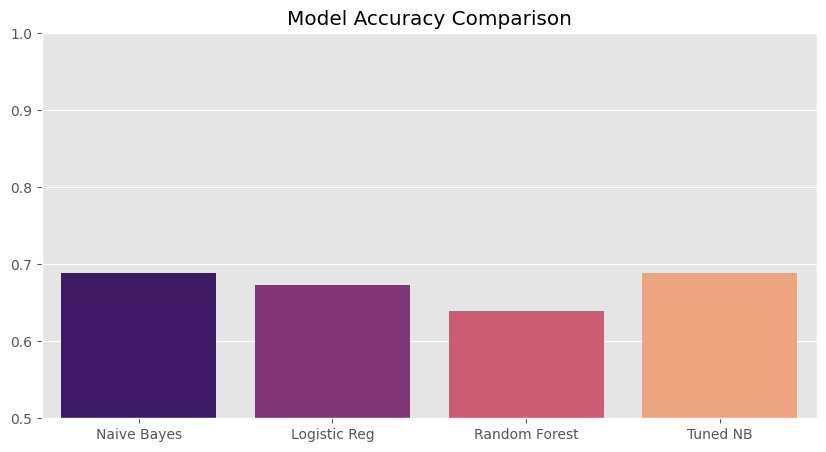

In [79]:
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=accs, palette='magma')
plt.title('Model Accuracy Comparison')
plt.ylim(0.5, 1.0)
plt.show()

In [81]:
def predict_new_text(text, vectorizer, model, encoder):
    cleaned = clean_text(text)
    lemmatized = lemmatize_text(cleaned)
    vec = vectorizer.transform([lemmatized])
    pred_idx = model.predict(vec)[0]
    return encoder.inverse_transform([pred_idx])[0]

In [82]:
txt1 = "Profit margins soared to new heights."
print(f"Text: {txt1} -> Sentiment: {predict_new_text(txt1, tfidf, best_nb, le)}")

Text: Profit margins soared to new heights. -> Sentiment: positive


In [84]:
txt2 = "The bankruptcy filing caused panic."
print(f"Text: {txt2} -> Sentiment: {predict_new_text(txt2, tfidf, best_nb, le)}")

Text: The bankruptcy filing caused panic. -> Sentiment: neutral


In [85]:
txt3 = "The meeting is scheduled for Tuesday."
print(f"Text: {txt3} -> Sentiment: {predict_new_text(txt3, tfidf, best_nb, le)}")

Text: The meeting is scheduled for Tuesday. -> Sentiment: neutral


In [86]:
joblib.dump(tfidf, f'{MODEL_DIR}/news_vectorizer.pkl')

['models/news_vectorizer.pkl']

In [87]:
joblib.dump(best_nb, f'{MODEL_DIR}/news_sentiment_model.pkl')

['models/news_sentiment_model.pkl']

In [88]:
joblib.dump(le, f'{MODEL_DIR}/news_label_encoder.pkl')

['models/news_label_encoder.pkl']

In [89]:
df.to_csv('data/news_processed_audit.csv', index=False)
print("Audit CSV saved.")

Audit CSV saved.


In [91]:
def plot_top_words(sentiment, n=10):
    text = ' '.join(df[df['Sentiment']==sentiment]['Final_Text'])
    vec = CountVectorizer().fit([text])
    bag = vec.transform([text])
    sum_words = bag.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    x, y = zip(*words_freq)
    plt.figure(figsize=(8, 4))
    plt.bar(x, y, color='teal')
    plt.title(f'Top words in {sentiment}')
    plt.xticks(rotation=45)
    plt.show()

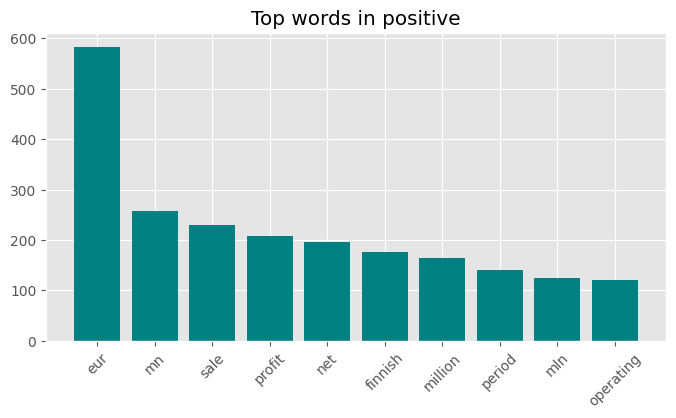

In [92]:
plot_top_words('positive')

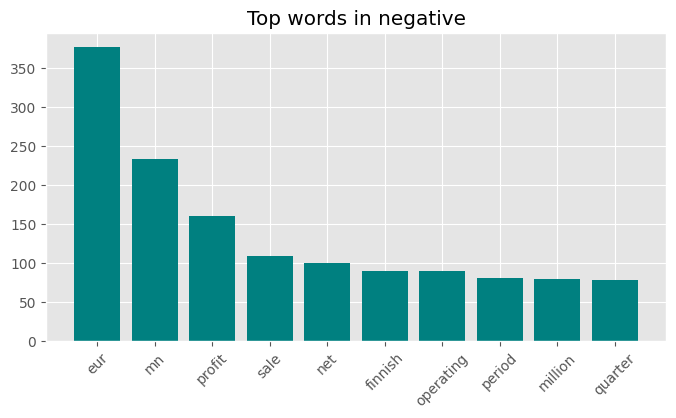

In [93]:
plot_top_words('negative')

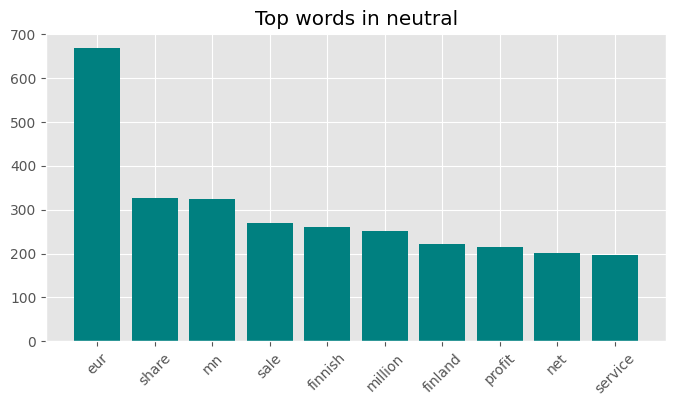

In [94]:
plot_top_words('neutral')

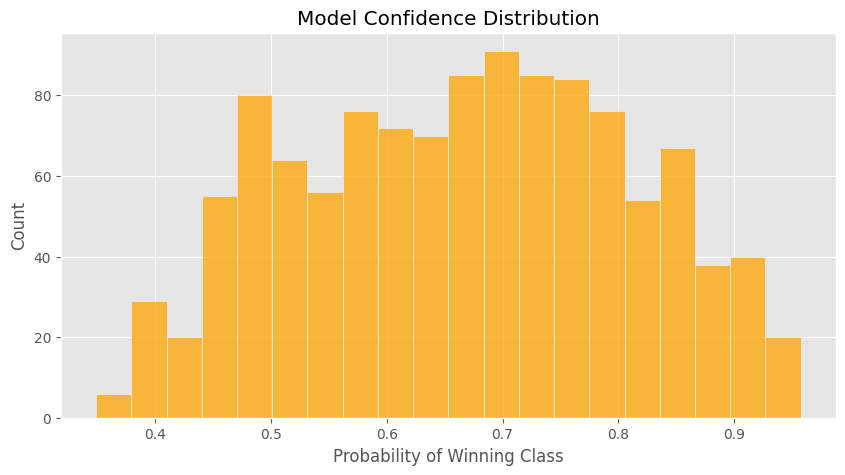

In [95]:
probs = best_nb.predict_proba(X_test)
max_probs = np.max(probs, axis=1)
plt.figure(figsize=(10, 5))
sns.histplot(max_probs, bins=20, color='orange')
plt.title('Model Confidence Distribution')
plt.xlabel('Probability of Winning Class')
plt.show()

In [96]:
print(os.path.exists(f'{MODEL_DIR}/news_sentiment_model.pkl'))

True
